# B Prime matrix operations

We are going to be using Alphagenome to interpret if a Transcription Factor is an activator or a repressor

### Existing DataSets

In [1]:
import seqlogo
import numpy as np
import pandas as pd
import anndata


import subprocess
import os

/home/nuvi/.local/lib/python3.11/site-packages/seqlogo/seqlogo.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
from Bio import motifs
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.motifs import meme

In [3]:
from constants import API_KEY

In [4]:
from alphagenome.data import gene_annotation

from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.data import ontology

from alphagenome.visualization import plot_components


from alphagenome.models import dna_client

/home/nuvi/.local/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.27.2 is exactly one major version older than the runtime version 6.31.1 at alphagenome/protos/dna_model.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/nuvi/.local/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.27.2 is exactly one major version older than the runtime version 6.31.1 at alphagenome/protos/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/nfs/turbo/umms-indikar/Ram/conda_envs/alphagenome/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nuvi/.local/lib/python3.11

In [5]:
from mapping import get_sorted_gene_order, generate_gene_id_name_map, get_master_regulator_list, get_TF_lists, get_a_matrix_threshold, load_htf_motifs, generate_gene_id_name_map, load_consensus

from genome_utils import write_meme_format, parse_fasta, write_df_to_meme

from constants import HTF_MOTIFS_DIR, CISBP_MOTIFS_DIR, REFERENCE_GENOME_PATH, GENCODE_ANNOTATION_PATH, REFERENCE_GTF_HG38_PATH, REFERENCE_DIR, TF_MOTIF_BASE_PATH

master_regulator_list = get_master_regulator_list()
repressorlist, activatorlist, conflictedlist, tf_list = get_TF_lists()

gene_id_name_map, gene_name_id_map = generate_gene_id_name_map()

total master regulators from Old list: 439
 Total Activators : 174
Total Reprossors : 705
Total Conflicted : 729
Total Transcription Factors : 1608
Extracted 43945 mappings from 73467 ensembl lines
Extracted 38606 mappings from gene id gtf file
Total Mappings Extracted 59979


In [6]:
tempdir = '/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp'



### Validation

To begin with, we take a single Trancription Factor and look at how it behaves with a target gene - Activates or repress, based on existing data 

In [7]:

b_matrix = anndata.read_h5ad('/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/operations/B_matrices_true.h5ad')

genes = b_matrix.var_names
TFs = b_matrix.obs_names


gene_counts = len(genes)
TF_counts = len(TFs)


print('TFs : ', gene_counts)
print('Genes : ' , TF_counts)

TFs :  19782
Genes :  1608


In [42]:
gene = 'PRRX1'
censensus, motif, gene_pwm = load_consensus(gene)

savepath = f'{tempdir}/{gene}.meme'

print('saving to path', savepath)

write_df_to_meme(gene_pwm, savepath, gene)
# write_meme_format(motif, savepath)

print(gene_pwm)

Extracted 43945 mappings from 73467 ensembl lines
Extracted 38606 mappings from gene id gtf file
Total Mappings Extracted 59979
Gene CIS-BP ID : M02957_3.00
/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/TF_MOTIFS/Homo_sapiens_2025_07_21_6_25_pm/pwms_all_motifs/M02957_3.00.txt
Consensus sequence: TGCCCTGGGGCA
saving to path /nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp/PRRX1.meme
    Pos         A         C         G         T
0     1  0.150629  0.210692  0.059434  0.579245
1     2  0.059840  0.121182  0.795944  0.023035
2     3  0.003292  0.872154  0.114403  0.010151
3     4  0.000000  0.969503  0.005185  0.025313
4     5  0.000000  0.532390  0.066981  0.400629
5     6  0.056307  0.279333  0.256370  0.407990
6     7  0.343504  0.213589  0.377163  0.065744
7     8  0.302830  0.047799  0.645912  0.003459
8     9  0.010579  0.000000  0.989110  0.000311
9    10  0.006598  0.074871  0.911933  0.006598
10   11  0.020569  0.641057  0.202863  0.135511
11   12  0.478138 

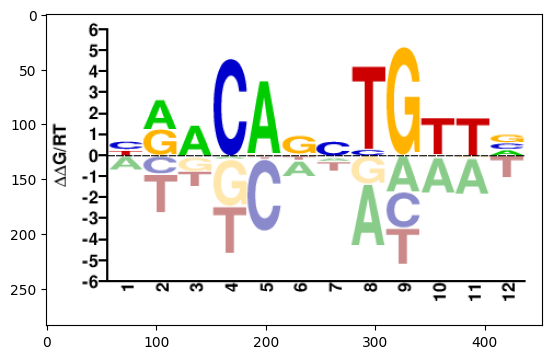

In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image_path = '/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/TF_MOTIFS/Homo_sapiens_2025_07_21_6_25_pm/logos_all_motifs/M04322_3.00_fwd.png'

img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)

# Show the plot window
plt.show()

In [10]:


gtf = pd.read_feather(REFERENCE_GTF_HG38_PATH)

# Filter to protein-coding genes and highly supported transcripts.
gtf_transcript = gene_annotation.filter_transcript_support_level(
    gene_annotation.filter_protein_coding(gtf), ['1']
)

# Define an extractor that fetches only the longest transcript per gene.
gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(
    gtf_transcript
)
longest_transcript_extractor = transcript_utils.TranscriptExtractor(
    gtf_longest_transcript
)


print(longest_transcript_extractor)

In [11]:
gtf.keys()

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_type', 'gene_name', 'level', 'tag',
       'transcript_id', 'transcript_type', 'transcript_name',
       'transcript_support_level', 'havana_transcript', 'exon_number',
       'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid',
       'artif_dupl'],
      dtype='object')

In [12]:
# helper functions

        
import matplotlib.pyplot as plt
    


def parse_unique_ids(value):
    return value.split('.')[0]

def parse_id_attr(row, keys, operation = parse_unique_ids):
    resdict = {}
    for key in keys:
        resdict[key] = operation(row[key])
        
    return pd.Series(resdict)

def pick_best_transcript(group):
    under_100kb = group[group["length"] <= 100000]
    if not under_100kb.empty:
        return under_100kb.sort_values("length", ascending=False).iloc[0]
    else:
        return group.sort_values("length", ascending=True).iloc[0]
        # group["dist_to_100kb"] = (group["length"] - 100_000).abs()
        # return group.sort_values("dist_to_100kb").iloc[0]



def plot_distribution(read_type, df, field):
    # Checking average gene length 
    
    
    mean_val = df[field].mean()
    median_val = df[field].median()
    max_val = df[field].max()
    
    print(f"Total {read_type}s: {len(df)}")
    print(f"Median {read_type} length: {median_val:,.0f} bp")
    print(f"Mean {read_type} length: {mean_val:,.0f} bp")
    print(f"Max {read_type} length: {max_val:,.0f} bp")
    
    
    plt.figure(figsize=(10,6))
    plt.hist(df[field], bins=100, color='skyblue', edgecolor='black', log=True)
    
    plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='r', linestyle=':', label=f'Median: {median_val:.2f}')

    
    plt.legend()

    plt.xlabel(f'{read_type} length (bp)')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Distribution of {read_type} Lengths (GENCODE v46)')
    plt.xlim(0, 2000000)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    # plt.savefig('figures/{read_type}_{field}s.png')


In [13]:
# Checking number of protein coding genes

unique_genes_df = gtf[gtf['Feature'] == 'gene'].copy()


keys = ['gene_id']
unique_genes_df[keys] = unique_genes_df.apply(
    parse_id_attr,
    axis=1,
    args=(keys, parse_unique_ids)
)

unique_genes_df = unique_genes_df[unique_genes_df['gene_type'] == 'protein_coding']

# Comparison of genes we have from different sources

genes_from_gtf = set(list(unique_genes_df.drop_duplicates("gene_id")['gene_id']))
genes_from_a_matrix = set(genes)

print(f'Total number of protein coding genes from GTF: {len(genes_from_gtf)}')
print(f'Total number of genes from A Matrix: {len(genes_from_a_matrix)}')
print(f'Total number of intersection: {len(genes_from_gtf.intersection(genes_from_a_matrix))}')


Total number of protein coding genes from GTF: 20065
Total number of genes from A Matrix: 19782
Total number of intersection: 19267


In [14]:
genes_df = gtf[gtf['Feature'] == 'gene'].copy()

keys = ['gene_id']
genes_df[keys] = genes_df.apply(
    parse_id_attr,
    axis=1,
    args=(keys, parse_unique_ids)
)

In [15]:
genes_df = genes_df[genes_df['gene_id'].isin(genes)].copy()

# genes_df = genes_df[genes_df['gene_type'] == 'protein_coding']


# calculate the length of each transcript which can then be filtered and ordered
genes_df['length'] = genes_df['End'] - genes_df['Start'] + 1


Total Genes: 19781
Median Gene length: 26,447 bp
Mean Gene length: 67,770 bp
Max Gene length: 2,473,540 bp


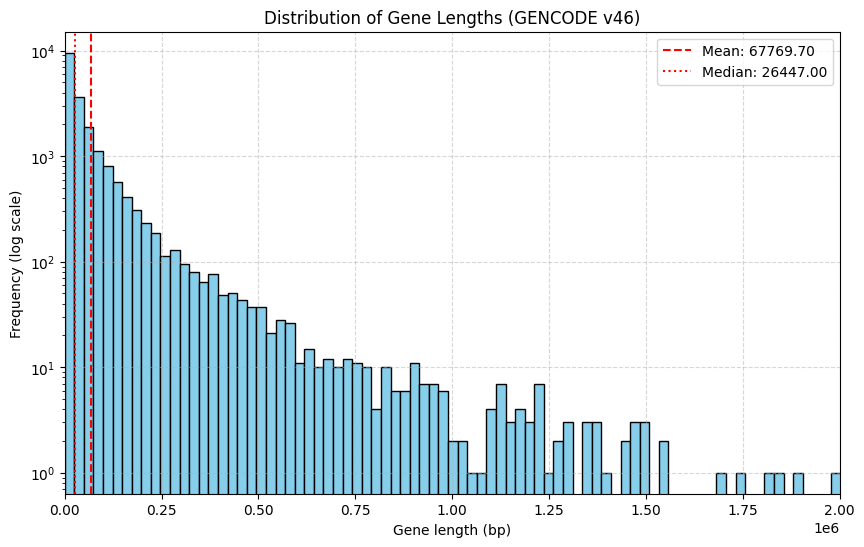

In [16]:

import matplotlib.pyplot as plt

# Checking average gene length 
read_type = 'Gene'
df = genes_df.copy()
attr = 'length'

plot_distribution(read_type, df, attr)



In [17]:
transcripts = gtf[gtf['Feature'] == 'transcript'].copy()


keys = ['gene_id', 'gene_type', 'transcript_id']
transcripts[keys] = transcripts.apply(
    parse_id_attr,
    axis=1,
    args=(keys, parse_unique_ids)
)

# WE extract the protein coding genes present in the B matrix
transcripts = transcripts[transcripts['gene_id'].isin(genes)].copy()

# calculate the length of each transcript which can then be filtered and ordered
transcripts['length'] = transcripts['End'] - transcripts['Start'] + 1

# transcripts are rarely greater than 100kb 
# transcripts = transcripts[transcripts['length'] < 100000].copy()


Total Transcripts: 170826
Median Transcript length: 16,145 bp
Mean Transcript length: 46,027 bp
Max Transcript length: 2,471,658 bp


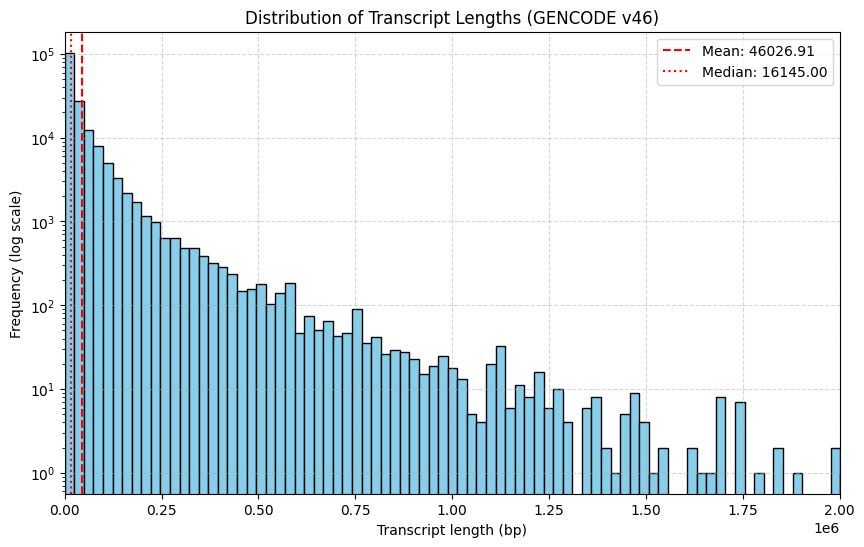

In [18]:

import matplotlib.pyplot as plt

# Checking average gene length 
read_type = 'Transcript'
df = transcripts.copy()
attr = 'length'

plot_distribution(read_type, df, attr)



In [19]:
transcript_to_gene = transcripts.copy()

transcript_to_gene = transcript_to_gene.merge(genes_df[['gene_id', 'length', 'Start']], on='gene_id', how='left')


# TSS occurs before the Gene start

transcript_to_gene['TSS_gene_distance'] = transcript_to_gene['Start_x'] - transcript_to_gene['Start_y'] 
print(transcript_to_gene)

       Chromosome  Source     Feature   Start_x       End Score Strand Frame  \
0            chr1  HAVANA  transcript     65418     71585     .      +     .   
1            chr1  HAVANA  transcript    450739    451678     .      -     .   
2            chr1  HAVANA  transcript    685715    686654     .      -     .   
3            chr1  HAVANA  transcript    923922    944574     .      +     .   
4            chr1  HAVANA  transcript    923922    944574     .      +     .   
...           ...     ...         ...       ...       ...   ...    ...   ...   
170821       chrY  HAVANA  transcript  57208518  57212183     .      +     .   
170822       chrY  HAVANA  transcript  57209305  57210051     .      +     .   
170823       chrY  HAVANA  transcript  57209886  57212186     .      +     .   
170824       chrY  HAVANA  transcript  57210343  57212074     .      +     .   
170825       chrY  HAVANA  transcript  57210590  57212074     .      +     .   

                gene_id       gene_type

Total TSS_gene_lengths: 170826
Median TSS_gene_length length: 1,835 bp
Mean TSS_gene_length length: 26,717 bp
Max TSS_gene_length length: 2,424,962 bp


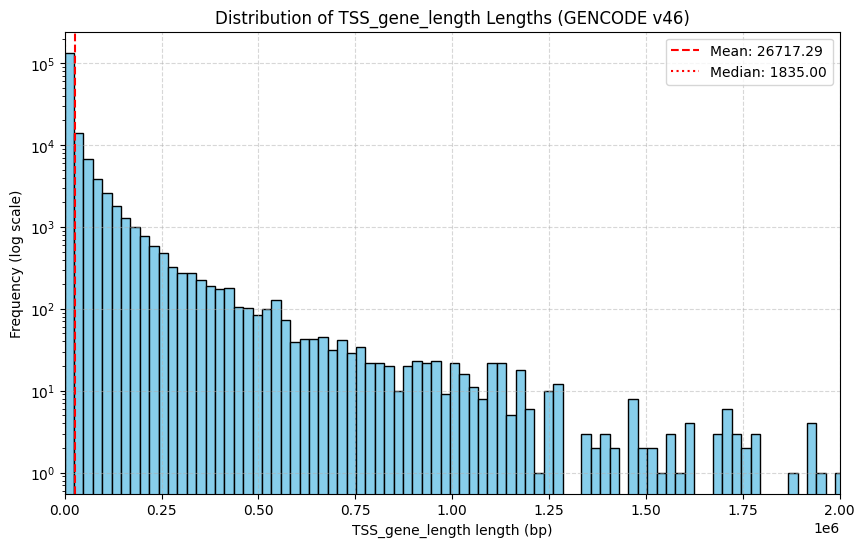

In [20]:

import matplotlib.pyplot as plt

# Checking average TSS to gene length 

read_type = 'TSS_gene_length'
df = transcript_to_gene.copy()
field = 'TSS_gene_distance'

plot_distribution(read_type, df, field)


### Transcript operations

We calculate the TSS as the start of the transcript site. Transcripts are the RNA transcripts for a particular gene. We know that transcripts should be < 100kb, but in case there is no transcript <100kb for a gene, we take the smallest transcript

/tmp/ipykernel_1217336/4168756671.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_transcripts = transcripts.groupby("gene_id", group_keys=False).apply(pick_best_transcript, include_groups=True)


Total Best Transcripts: 19781
Median Best Transcript length: 23,606 bp
Mean Best Transcript length: 35,079 bp
Max Best Transcript length: 1,369,274 bp


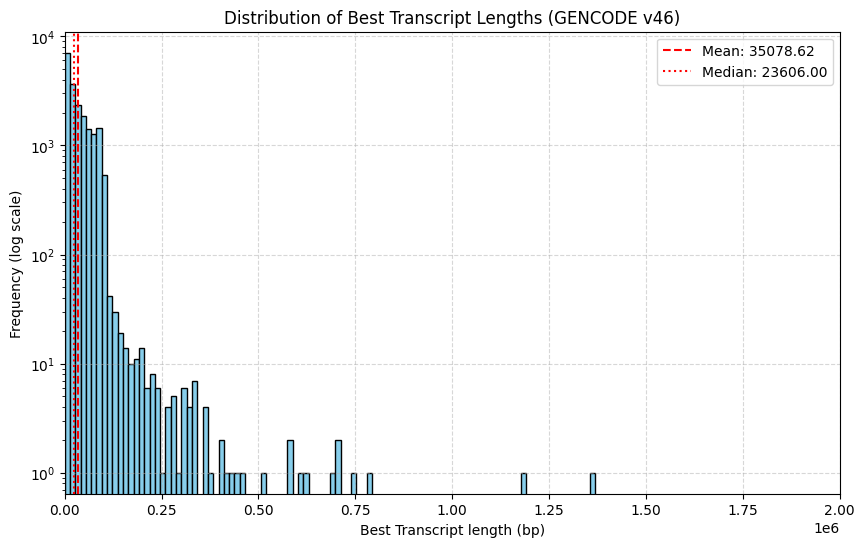

In [21]:


# calculate the length of each transcript which can then be filtered and ordered
transcripts['length'] = transcripts['End'] - transcripts['Start'] + 1
# print(transcripts)

best_transcripts = transcripts.groupby("gene_id", group_keys=False).apply(pick_best_transcript, include_groups=True)

# print(best_transcripts)
# 
# best_transcripts = transcripts.groupby("gene_id", group_keys=False).apply(
#     lambda group: pick_best_transcript(group), include_groups=False
# )


import matplotlib.pyplot as plt

# Checking average gene length 
read_type = 'Best Transcript'
attr = 'length'

plot_distribution(read_type, best_transcripts, attr)




In [22]:
best_transcripts.keys()

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_type', 'gene_name', 'level', 'tag',
       'transcript_id', 'transcript_type', 'transcript_name',
       'transcript_support_level', 'havana_transcript', 'exon_number',
       'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid',
       'artif_dupl', 'length'],
      dtype='object')

In [23]:
# Get the TSS FLanking region


bed_csv = f"{REFERENCE_DIR}/protein_coding_tss_flank_10kb.bed"

fifty_kb_flanks = f"{REFERENCE_DIR}/protein_coding_tss_flank_50kb.bed"
one_mb_flanks = f"{REFERENCE_DIR}/protein_coding_tss_flank_1mb.bed"
two_mb_flanks = f"{REFERENCE_DIR}/protein_coding_tss_flank_2mb.bed"


def get_tss_flank(row, flank=1000):
    if row["Strand"] == "+":
        tss = row["Start"]
        flank_start = max(0, tss - flank)
        flank_end = tss + flank
    else:
        tss = row["End"]
        flank_start = max(0, tss - flank)
        flank_end = tss + flank
    return pd.Series([flank_start, flank_end])


if not os.path.exists(bed_csv):
    best_transcripts[["flank_start", "flank_end"]] = best_transcripts.apply(get_tss_flank, axis=1, args=(10000,))
    
    
    
    bed = best_transcripts[["Chromosome", "flank_start", "flank_end", "gene_id", "Strand", "Score"]].copy()
    bed = bed[["Chromosome", "flank_start", "flank_end", "gene_id", "Score", "Strand"]]
    
    bed.to_csv(bed_csv, sep="\t", header=False, index=False)
else:
    bed = pd.read_csv(bed_csv, sep="\t")


if not os.path.exists(fifty_kb_flanks):
    best_transcripts[["flank_start", "flank_end"]] = best_transcripts.apply(get_tss_flank, axis=1, args=(250000,))
    
    
    
    bed_fifty_k = best_transcripts[["Chromosome", "flank_start", "flank_end", "gene_id", "Strand", "Score"]].copy()
    bed_fifty_k = bed_fifty_k[["Chromosome", "flank_start", "flank_end", "gene_id", "Score", "Strand"]]
    print("processed fifty kb flank region")
    
    bed_fifty_k.to_csv(fifty_kb_flanks, sep="\t", header=False, index=False)
else:
    bed_fifty_k = pd.read_csv(fifty_kb_flanks, sep="\t", header=None)




if not os.path.exists(one_mb_flanks):
    best_transcripts[["flank_start", "flank_end"]] = best_transcripts.apply(get_tss_flank, axis=1, args=(500000,))
    
    
    
    bed_one_m = best_transcripts[["Chromosome", "flank_start", "flank_end", "gene_id", "Strand", "Score"]].copy()
    bed_one_m = bed_one_m[["Chromosome", "flank_start", "flank_end", "gene_id", "Score", "Strand"]]
    
    bed_one_m.to_csv(one_mb_flanks, sep="\t", header=False, index=False)
else:
    bed_one_m= pd.read_csv(one_mb_flanks, sep="\t", header=None)



if not os.path.exists(two_mb_flanks):
    best_transcripts[["flank_start", "flank_end"]] = best_transcripts.apply(get_tss_flank, axis=1, args=(1000000,))
    
    
    
    bed_two_m = best_transcripts[["Chromosome", "flank_start", "flank_end", "gene_id", "Strand", "Score"]].copy()
    bed_two_m = bed_two_m[["Chromosome", "flank_start", "flank_end", "gene_id", "Score", "Strand"]]
    
    bed_two_m.to_csv(two_mb_flanks, sep="\t", header=False, index=False)
else:
    bed_two_m= pd.read_csv(two_mb_flanks, sep="\t", header=None)


processed fifty kb flank region


In [45]:
bed_one_chr19 = bed_one_m[(bed_one_m[0] == 'chr19') & (bed_one_m[5]=='+')]
bed_two_chr19 = bed_two_m[(bed_two_m[0] == 'chr19') & (bed_two_m[5]=='+')]

bed_one_chr19

,0,1,2,3,4,5
57,chr19,35275514,36275514,ENSG00000004777,.,+
72,chr19,18331958,19331958,ENSG00000005007,.,+
86,chr19,1828683,2828683,ENSG00000005206,.,+
114,chr19,18088684,19088684,ENSG00000006015,.,+
148,chr19,39204480,40204480,ENSG00000006659,.,+
...,...,...,...,...,...,...
19471,chr19,4403079,5403079,ENSG00000276043,.,+
19538,chr19,57778954,58778954,ENSG00000278129,.,+
19665,chr19,35086172,36086172,ENSG00000283758,.,+
19668,chr19,12187997,13187997,ENSG00000283980,.,+


## Running FIMO matching

fimo command :  fimo --oc fimo_out /nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp/PRRX1.meme promoters.fa




input

In [18]:
from constants import REFERENCE_CHROM_SIZES_PATH, REFERENCE_GENES_BED_PATH, REFERENCE_GENOME_PATH

print(REFERENCE_CHROM_SIZES_PATH)
print(REFERENCE_GENES_BED_PATH)
print(REFERENCE_GENOME_PATH)

/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/hg38.chrom.sizes
/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/genes.bed
/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/hg38.fa


### Operations

In order to fetch the promoter regions for each gene, We download the reference genome, and use bedtools to fetch the scaffold regions

- To keep only the clean chromosomes : grep -v "_" genes.bed > genes.filtered.bed 
- To extract Scaffold regions of +1000 and -1000 :  bedtools flank -i /scratch/indikar_root/indikar1/shared_data/HWG/data/REFERENCE/genes.filtered.bed -g /scratch/indikar_root/indikar1/shared_data/HWG/data/REFERENCE/hg38.chrom.sizes -l 1000 -r 100 -s > promoters.bed
- To extract the regions from the reference genome : bedtools getfasta -fi /nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/hg38_genome/ncbi_dataset/data/GCF_000001405.40/GCF_000001405.40_GRCh38.p14_genomic.fna -bed promoters.bed > promoters.fa
- Now scanning for motifs with FIMO : fimo --oc fimo_out motif.meme promoters.fa

For a slight change in logic.
instead of using 1000 on 5' and 100 on 3', we consider +- 10kb around the Transcription Start Site as the flank for promoter region.

In [27]:
fimo_file = '/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp/promoter_operations/fimo_out/fimo.tsv'

pd.read_csv(fimo_file, sep='\t')

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
1,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
2,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
3,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
4,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
...,...,...,...,...,...,...,...,...,...,...
41575,PRRX1,NaN,chr1,248859934.0,248859941.0,-,10.4059,0.000088,1.0,CTAATTAG
41576,PRRX1,NaN,chr1,248859934.0,248859941.0,-,10.4059,0.000088,1.0,CTAATTAG
41577,# FIMO (Find Individual Motif Occurrences): Ve...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41578,# The format of this file is described at http...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Select the base gene

This is the gene with the most number of TFs acting on it. This enables us to have a large set of validation data.

We then take known activators and repressors for this gene. 

In [15]:
# Gene with most available data

import numpy as np

adata = b_matrix

X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

one_counts = np.sum(X == 1, axis=0)

max_idx = np.argmax(one_counts)

gene_id = adata.var_names[max_idx]
count_ones = one_counts[max_idx]

mask = adata[:, gene_id].X.flatten() == 1
adata_filtered = adata[mask, gene_id]

gene_interactions = list(adata_filtered.obs_names)

# print(gen_interactions)

print(f"Variable with most 1s: {gene_id} ({count_ones} ones)")


Variable with most 1s: ENSG00000063244 (887 ones)


In [16]:
base_gene_name = gene_id_name_map.get(gene_id)
base_gene_id = gene_id
print("Gene : ", base_gene_name)
print("Gene ID: ", gene_id)


Gene :  U2AF2
Gene ID:  ENSG00000063244


In [17]:
gene_interactionset = set(gene_interactions)

repressor_tfs = gene_interactionset.intersection(repressorlist)
activator_tfs = gene_interactionset.intersection(activatorlist)
conflicted_tfs = gene_interactionset.intersection(conflictedlist)

print("Repressor overlap: ", len(repressor_tfs))
print("Activator overlap: ", len(activator_tfs))
print("conflicted overlap: ", len(conflicted_tfs))

Repressor overlap:  350
Activator overlap:  102
conflicted overlap:  435


In [31]:
# THis will be the Transcription factor we will be replacing with the actual tf


base_tf = list(conflicted_tfs)[1]

print('Base Transcription Factor: ', base_tf)
base_tf_name = gene_id_name_map.get(base_tf)

print('Base Transcription Factor Name: ', base_tf_name)

censensus, motif, gene_pwm = load_consensus(base_tf_name, gene_id=base_tf)

savepath = f'{tempdir}/{base_tf}.meme'

print('saving to path', savepath)

write_df_to_meme(gene_pwm, savepath, base_tf)
# write_meme_format(motif, savepath)

print(gene_pwm)
print(savepath)

Base Transcription Factor:  ENSG00000117139
Base Transcription Factor Name:  KDM5B
Gene CIS-BP ID : M02957_3.00
/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/TF_MOTIFS/Homo_sapiens_2025_07_21_6_25_pm/pwms_all_motifs/M02957_3.00.txt
Consensus sequence: TGCCCTGGGGCA
saving to path /nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp/ENSG00000117139.meme
    Pos         A         C         G         T
0     1  0.150629  0.210692  0.059434  0.579245
1     2  0.059840  0.121182  0.795944  0.023035
2     3  0.003292  0.872154  0.114403  0.010151
3     4  0.000000  0.969503  0.005185  0.025313
4     5  0.000000  0.532390  0.066981  0.400629
5     6  0.056307  0.279333  0.256370  0.407990
6     7  0.343504  0.213589  0.377163  0.065744
7     8  0.302830  0.047799  0.645912  0.003459
8     9  0.010579  0.000000  0.989110  0.000311
9    10  0.006598  0.074871  0.911933  0.006598
10   11  0.020569  0.641057  0.202863  0.135511
11   12  0.478138  0.056622  0.240013  0.225228
/nfs/

In [32]:
# Running through each of the conflicted TFS to get the best base TF


tf_match_dict = {}

conflicted_tflist = list(conflicted_tfs)

for i in range(len(conflicted_tflist)):
    base_tf = conflicted_tflist[i]

    try:
        print('Base Transcription Factor: ', base_tf)
        base_tf_name = gene_id_name_map.get(base_tf)
        
        print('Base Transcription Factor Name: ', base_tf_name)
        
        censensus, motif, gene_pwm = load_consensus(base_tf_name, gene_id=base_tf)
        
        savepath = f'{tempdir}/{base_tf}.meme'
        
        print('saving to path', savepath)
        
        write_df_to_meme(gene_pwm, savepath, base_tf)
        # write_meme_format(motif, savepath)
        
        print(gene_pwm)
        print(savepath)
    except:
        print(f'failed for TF: {base_tf}')
        continue
    
    
    
    # fimo_outpath = '/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/fimo_U2AF2_out'
    fa_path = '/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/promoters_U2AF2.fa'
    # subcommand = ['fimo', ' --oc', fimo_outpath, savepath, fa_path ]
    subcommand = f'fimo {savepath} {fa_path}'

    try:
        result = subprocess.run(subcommand, shell=True, capture_output=True, text=True, check=True)
        print(result.stdout)
        fimo_tsv_out = pd.read_csv( 'fimo_out/fimo.tsv', sep='\t')
        
        tf_match_dict[base_tf] = len(fimo_tsv_out)
    
    except:
        print(f'failed Running FIMO for: {base_tf}')
    

Base Transcription Factor:  ENSG00000234284
Base Transcription Factor Name:  ZNF879
Gene CIS-BP ID : M02957_3.00
/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/TF_MOTIFS/Homo_sapiens_2025_07_21_6_25_pm/pwms_all_motifs/M02957_3.00.txt
Consensus sequence: TGCCCTGGGGCA
saving to path /nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp/ENSG00000234284.meme
    Pos         A         C         G         T
0     1  0.150629  0.210692  0.059434  0.579245
1     2  0.059840  0.121182  0.795944  0.023035
2     3  0.003292  0.872154  0.114403  0.010151
3     4  0.000000  0.969503  0.005185  0.025313
4     5  0.000000  0.532390  0.066981  0.400629
5     6  0.056307  0.279333  0.256370  0.407990
6     7  0.343504  0.213589  0.377163  0.065744
7     8  0.302830  0.047799  0.645912  0.003459
8     9  0.010579  0.000000  0.989110  0.000311
9    10  0.006598  0.074871  0.911933  0.006598
10   11  0.020569  0.641057  0.202863  0.135511
11   12  0.478138  0.056622  0.240013  0.225228
/nfs

In [33]:
tf_with_highest_matches = max(tf_match_dict, key=tf_match_dict.get)

print(tf_with_highest_matches)

sorted_items_asc = sorted(tf_match_dict.items(), key=lambda item: item[1], reverse=True)
print(f"Sorted items (descending by value): {sorted_items_asc[:10]}")

base_tf, count = sorted_items_asc[100]

ENSG00000234284
Sorted items (descending by value): [('ENSG00000234284', 27), ('ENSG00000117139', 27), ('ENSG00000173480', 27), ('ENSG00000107485', 27), ('ENSG00000147596', 27), ('ENSG00000189144', 27), ('ENSG00000214022', 27), ('ENSG00000065526', 27), ('ENSG00000198538', 27), ('ENSG00000196418', 27)]


### TF with the top interaction

In [31]:
base_tf = 'ENSG00000256087'


print('Base Transcription Factor: ', base_tf)
base_tf_name = gene_id_name_map.get(base_tf)

print('Base Transcription Factor Name: ', base_tf_name)

censensus, motif, gene_pwm = load_consensus(base_tf_name, gene_id=base_tf)

savepath = f'{tempdir}/{base_tf}.meme'

print('saving to path', savepath)

write_df_to_meme(gene_pwm, savepath, base_tf)
# write_meme_format(motif, savepath)

print(gene_pwm)
print(savepath)


tf_match_dict = {}


fa_path = '/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/promoters_U2AF2.fa'
# subcommand = ['fimo', ' --oc', fimo_outpath, savepath, fa_path ]
subcommand = f'fimo {savepath} {fa_path}'

try:
    result = subprocess.run(subcommand, shell=True, capture_output=True, text=True, check=True)
    print(result.stdout)
    fimo_tsv_out = pd.read_csv( 'fimo_out/fimo.tsv', sep='\t')

    
    tf_match_dict[base_tf] = len(fimo_tsv_out)

except Exception as e:
    print(e)
    print(f'failed Running FIMO for: {base_tf}')

Base Transcription Factor:  ENSG00000256087
Base Transcription Factor Name:  ZNF432
Gene CIS-BP ID : M02957_3.00
/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/TF_MOTIFS/Homo_sapiens_2025_07_21_6_25_pm/pwms_all_motifs/M02957_3.00.txt
Consensus sequence: TGCCCTGGGGCA
saving to path /nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp/ENSG00000256087.meme
    Pos         A         C         G         T
0     1  0.150629  0.210692  0.059434  0.579245
1     2  0.059840  0.121182  0.795944  0.023035
2     3  0.003292  0.872154  0.114403  0.010151
3     4  0.000000  0.969503  0.005185  0.025313
4     5  0.000000  0.532390  0.066981  0.400629
5     6  0.056307  0.279333  0.256370  0.407990
6     7  0.343504  0.213589  0.377163  0.065744
7     8  0.302830  0.047799  0.645912  0.003459
8     9  0.010579  0.000000  0.989110  0.000311
9    10  0.006598  0.074871  0.911933  0.006598
10   11  0.020569  0.641057  0.202863  0.135511
11   12  0.478138  0.056622  0.240013  0.225228
/nfs

In [36]:
print(fimo_tsv_out)
print("Motif Length: ", len(fimo_tsv_out['matched_sequence'][0]))

                                              motif_id  motif_alt_id  \
0                                      ENSG00000256087           NaN   
1                                      ENSG00000256087           NaN   
2                                      ENSG00000256087           NaN   
3                                      ENSG00000256087           NaN   
4                                      ENSG00000256087           NaN   
..                                                 ...           ...   
363                                    ENSG00000256087           NaN   
364                                    ENSG00000256087           NaN   
365  # FIMO (Find Individual Motif Occurrences): Ve...           NaN   
366  # The format of this file is described at http...           NaN   
367  # fimo /nfs/turbo/umms-indikar/shared/projects...           NaN   

    sequence_name       start        stop strand     score       p-value  \
0           chr19  55662369.0  55662398.0      +  29.78220 

# Replacement function

Most important function to replace motifs.
Code should handle overlapping regions, large motifs, small motifs and motifs beyond the flank

In [28]:
valid_tf_list = []

tflist = list(repressor_tfs)


for i in range(len(tflist)):
    base_tf = tflist[i]

    try:
        print('Base Transcription Factor: ', base_tf)
        base_tf_name = gene_id_name_map.get(base_tf)
        
        print('Base Transcription Factor Name: ', base_tf_name)
        
        censensus, motif, gene_pwm = load_consensus(base_tf_name, gene_id=base_tf)
        
        savepath = f'{tempdir}/{base_tf}.meme'
        
        print('saving to path', savepath)
        
        write_df_to_meme(gene_pwm, savepath, base_tf)
        # write_meme_format(motif, savepath)
        
        print(gene_pwm)
        print(savepath)
    except:
        print(f'failed for TF: {base_tf}')
        continue
    valid_tf_list.append(base_tf)

NameError: name 'repressor_tfs' is not defined

In [54]:
print(valid_tf_list)

['ENSG00000261787', 'ENSG00000186814', 'ENSG00000175592', 'ENSG00000178403', 'ENSG00000186496', 'ENSG00000114861', 'ENSG00000204859', 'ENSG00000132005', 'ENSG00000197579', 'ENSG00000147421', 'ENSG00000137709', 'ENSG00000198517', 'ENSG00000185670', 'ENSG00000130675', 'ENSG00000079432', 'ENSG00000173153', 'ENSG00000171163', 'ENSG00000128713', 'ENSG00000163909', 'ENSG00000150347', 'ENSG00000156150', 'ENSG00000140262', 'ENSG00000196653', 'ENSG00000126561', 'ENSG00000084093', 'ENSG00000196233', 'ENSG00000197905', 'ENSG00000135374', 'ENSG00000144355', 'ENSG00000203326', 'ENSG00000162599', 'ENSG00000143842', 'ENSG00000197951', 'ENSG00000119138', 'ENSG00000179922', 'ENSG00000188620', 'ENSG00000136352', 'ENSG00000205250', 'ENSG00000197576', 'ENSG00000170608', 'ENSG00000254004', 'ENSG00000115816', 'ENSG00000198146', 'ENSG00000163792', 'ENSG00000043355', 'ENSG00000113196', 'ENSG00000188283', 'ENSG00000177873', 'ENSG00000129173', 'ENSG00000110693', 'ENSG00000113916', 'ENSG00000214513', 'ENSG000001

In [46]:
valid_conflicted = ['ENSG00000196605', 'ENSG00000175322', 'ENSG00000251493', 'ENSG00000171295', 'ENSG00000139083', 'ENSG00000267680', 'ENSG00000115415', 'ENSG00000256294', 'ENSG00000197714', 'ENSG00000204604', 'ENSG00000198046', 'ENSG00000196172', 'ENSG00000137504', 'ENSG00000177606', 'ENSG00000167555', 'ENSG00000178386', 'ENSG00000116833', 'ENSG00000164916', 'ENSG00000198538', 'ENSG00000081665', 'ENSG00000171469', 'ENSG00000142556', 'ENSG00000196646', 'ENSG00000120068', 'ENSG00000214029', 'ENSG00000066136', 'ENSG00000186350', 'ENSG00000167182', 'ENSG00000181638', 'ENSG00000186300', 'ENSG00000178187', 'ENSG00000182986', 'ENSG00000188785', 'ENSG00000214575', 'ENSG00000169740', 'ENSG00000180257', 'ENSG00000196453', 'ENSG00000114439', 'ENSG00000154957', 'ENSG00000168610', 'ENSG00000196378', 'ENSG00000171574', 'ENSG00000173875', 'ENSG00000269404', 'ENSG00000221923', 'ENSG00000143437', 'ENSG00000107485', 'ENSG00000144792', 'ENSG00000123358', 'ENSG00000152467', 'ENSG00000107807', 'ENSG00000081059', 'ENSG00000138378', 'ENSG00000139651', 'ENSG00000130522', 'ENSG00000173258', 'ENSG00000065970', 'ENSG00000175787', 'ENSG00000064489', 'ENSG00000123933', 'ENSG00000197372', 'ENSG00000185960', 'ENSG00000124092', 'ENSG00000130544', 'ENSG00000196418', 'ENSG00000156273', 'ENSG00000196466', 'ENSG00000186448', 'ENSG00000157429', 'ENSG00000197472', 'ENSG00000196458', 'ENSG00000123405', 'ENSG00000126746', 'ENSG00000198429', 'ENSG00000063515', 'ENSG00000151702', 'ENSG00000256229', 'ENSG00000198482', 'ENSG00000106459', 'ENSG00000167377', 'ENSG00000196357', 'ENSG00000198353', 'ENSG00000167081', 'ENSG00000143995', 'ENSG00000131196', 'ENSG00000197124', 'ENSG00000198939', 'ENSG00000162992', 'ENSG00000196705', 'ENSG00000198040', 'ENSG00000147117', 'ENSG00000174197', 'ENSG00000196417', 'ENSG00000102349', 'ENSG00000197044', 'ENSG00000160961', 'ENSG00000120784', 'ENSG00000196214', 'ENSG00000120075', 'ENSG00000181827', 'ENSG00000131127', 'ENSG00000197647', 'ENSG00000197933', 'ENSG00000182983', 'ENSG00000171291', 'ENSG00000142065', 'ENSG00000121075', 'ENSG00000147124', 'ENSG00000185811', 'ENSG00000186790', 'ENSG00000197020', 'ENSG00000171827', 'ENSG00000167637', 'ENSG00000136574', 'ENSG00000172006', 'ENSG00000180479', 'ENSG00000182742', 'ENSG00000158711', 'ENSG00000119574', 'ENSG00000167685', 'ENSG00000119866', 'ENSG00000130844', 'ENSG00000198342', 'ENSG00000213988', 'ENSG00000129514', 'ENSG00000109381', 'ENSG00000249709', 'ENSG00000159556', 'ENSG00000152804', 'ENSG00000107859', 'ENSG00000173041', 'ENSG00000205922', 'ENSG00000267508', 'ENSG00000167384', 'ENSG00000197024', 'ENSG00000089225', 'ENSG00000213020', 'ENSG00000186020', 'ENSG00000197863', 'ENSG00000083844', 'ENSG00000125846', 'ENSG00000196693', 'ENSG00000196482', 'ENSG00000198551', 'ENSG00000179348', 'ENSG00000167562', 'ENSG00000237440', 'ENSG00000121406', 'ENSG00000037965', 'ENSG00000256683', 'ENSG00000169083', 'ENSG00000125820', 'ENSG00000204611', 'ENSG00000162714', 'ENSG00000189042', 'ENSG00000196345', 'ENSG00000172216', 'ENSG00000170265', 'ENSG00000214336', 'ENSG00000197013', 'ENSG00000198039', 'ENSG00000105136', 'ENSG00000131061', 'ENSG00000189164', 'ENSG00000116604', 'ENSG00000169131', 'ENSG00000178935', 'ENSG00000116017', 'ENSG00000134852', 'ENSG00000178150', 'ENSG00000189180', 'ENSG00000135457', 'ENSG00000162086', 'ENSG00000189144', 'ENSG00000141905', 'ENSG00000180855', 'ENSG00000087510', 'ENSG00000083812', 'ENSG00000159885', 'ENSG00000101076', 'ENSG00000122386', 'ENSG00000171817', 'ENSG00000184635', 'ENSG00000204947', 'ENSG00000112658', 'ENSG00000229676', 'ENSG00000006468', 'ENSG00000249471', 'ENSG00000184486', 'ENSG00000142409', 'ENSG00000168214', 'ENSG00000178573', 'ENSG00000168310', 'ENSG00000188629', 'ENSG00000119725', 'ENSG00000180626', 'ENSG00000234284', 'ENSG00000143178', 'ENSG00000102034', 'ENSG00000152433', 'ENSG00000182111', 'ENSG00000028277', 'ENSG00000181007', 'ENSG00000184939', 'ENSG00000147789', 'ENSG00000025434', 'ENSG00000175197', 'ENSG00000148737', 'ENSG00000134138', 'ENSG00000173480', 'ENSG00000020633', 'ENSG00000159917', 'ENSG00000007968', 'ENSG00000167554', 'ENSG00000198185', 'ENSG00000188295', 'ENSG00000127081', 'ENSG00000118620', 'ENSG00000169957', 'ENSG00000177842', 'ENSG00000188171', 'ENSG00000125798', 'ENSG00000257923', 'ENSG00000183647', 'ENSG00000251247', 'ENSG00000136931', 'ENSG00000054598', 'ENSG00000128714', 'ENSG00000176293', 'ENSG00000164256', 'ENSG00000101216', 'ENSG00000197362', 'ENSG00000077150', 'ENSG00000172789', 'ENSG00000162924', 'ENSG00000083828', 'ENSG00000186446', 'ENSG00000167785', 'ENSG00000256087', 'ENSG00000197162', 'ENSG00000075426', 'ENSG00000118058', 'ENSG00000187079', 'ENSG00000120837', 'ENSG00000160199', 'ENSG00000160685', 'ENSG00000180535', 'ENSG00000197134', 'ENSG00000275111', 'ENSG00000138795', 'ENSG00000213096', 'ENSG00000125952', 'ENSG00000141946', 'ENSG00000188227', 'ENSG00000198464', 'ENSG00000100105', 'ENSG00000154727', 'ENSG00000186026', 'ENSG00000251192', 'ENSG00000125850', 'ENSG00000186017', 'ENSG00000213015', 'ENSG00000156127', 'ENSG00000126456', 'ENSG00000171872', 'ENSG00000189298', 'ENSG00000197857', 'ENSG00000172748', 'ENSG00000197360', 'ENSG00000120690', 'ENSG00000186272', 'ENSG00000118260', 'ENSG00000181666', 'ENSG00000197928', 'ENSG00000068305', 'ENSG00000149922', 'ENSG00000083307', 'ENSG00000141040', 'ENSG00000180787', 'ENSG00000106261', 'ENSG00000179909', 'ENSG00000178860', 'ENSG00000198556', 'ENSG00000018869', 'ENSG00000141646', 'ENSG00000121417', 'ENSG00000196387', 'ENSG00000178917', 'ENSG00000117010', 'ENSG00000256223', 'ENSG00000170653', 'ENSG00000123407', 'ENSG00000106536', 'ENSG00000006194', 'ENSG00000131408', 'ENSG00000160352', 'ENSG00000111424', 'ENSG00000128709', 'ENSG00000184517', 'ENSG00000147596', 'ENSG00000196724', 'ENSG00000196967', 'ENSG00000170577', 'ENSG00000243660', 'ENSG00000196391', 'ENSG00000105750', 'ENSG00000197841', 'ENSG00000108788', 'ENSG00000165512', 'ENSG00000154832', 'ENSG00000196150', 'ENSG00000105698', 'ENSG00000010539', 'ENSG00000177463', 'ENSG00000176024', 'ENSG00000178229', 'ENSG00000178665', 'ENSG00000100811', 'ENSG00000188033']

valid_activators = ['ENSG00000073282', 'ENSG00000136997', 'ENSG00000137309', 'ENSG00000196628', 'ENSG00000187098', 'ENSG00000134954', 'ENSG00000105497', 'ENSG00000198911', 'ENSG00000105866', 'ENSG00000198176', 'ENSG00000105991', 'ENSG00000164107', 'ENSG00000134323', 'ENSG00000153879', 'ENSG00000244405', 'ENSG00000143190', 'ENSG00000170345', 'ENSG00000151615', 'ENSG00000066336', 'ENSG00000230797', 'ENSG00000196092', 'ENSG00000176887', 'ENSG00000143257', 'ENSG00000009950', 'ENSG00000120738', 'ENSG00000181449', 'ENSG00000157554', 'ENSG00000173039', 'ENSG00000245848', 'ENSG00000078900', 'ENSG00000179388', 'ENSG00000184481', 'ENSG00000124766', 'ENSG00000113658', 'ENSG00000129152', 'ENSG00000067082', 'ENSG00000125347', 'ENSG00000109320', 'ENSG00000141448', 'ENSG00000111206', 'ENSG00000166478', 'ENSG00000171223', 'ENSG00000172819', 'ENSG00000177732', 'ENSG00000068323', 'ENSG00000125398', 'ENSG00000102145', 'ENSG00000115966', 'ENSG00000101412', 'ENSG00000213676', 'ENSG00000106031', 'ENSG00000136826', 'ENSG00000112242', 'ENSG00000150907', 'ENSG00000128272', 'ENSG00000185697', 'ENSG00000104856', 'ENSG00000166949', 'ENSG00000204304', 'ENSG00000105392', 'ENSG00000124813', 'ENSG00000204103', 'ENSG00000198815', 'ENSG00000171056', 'ENSG00000103495', 'ENSG00000137203', 'ENSG00000185507', 'ENSG00000175832', 'ENSG00000131759', 'ENSG00000124664', 'ENSG00000181690', 'ENSG00000101057', 'ENSG00000165588', 'ENSG00000126767', 'ENSG00000163435', 'ENSG00000132170', 'ENSG00000198081', 'ENSG00000221869', 'ENSG00000123268', 'ENSG00000185591', 'ENSG00000007372', 'ENSG00000082641', 'ENSG00000169136', 'ENSG00000108511', 'ENSG00000173757', 'ENSG00000165556', 'ENSG00000158773', 'ENSG00000185122', 'ENSG00000001167', 'ENSG00000091831', 'ENSG00000102554', 'ENSG00000118689']

valid_repressors = ['ENSG00000261787', 'ENSG00000186814', 'ENSG00000175592', 'ENSG00000178403', 'ENSG00000186496', 'ENSG00000114861', 'ENSG00000204859', 'ENSG00000132005', 'ENSG00000197579', 'ENSG00000147421', 'ENSG00000137709', 'ENSG00000198517', 'ENSG00000185670', 'ENSG00000130675', 'ENSG00000079432', 'ENSG00000173153', 'ENSG00000171163', 'ENSG00000128713', 'ENSG00000163909', 'ENSG00000150347', 'ENSG00000156150', 'ENSG00000140262', 'ENSG00000196653', 'ENSG00000126561', 'ENSG00000084093', 'ENSG00000196233', 'ENSG00000197905', 'ENSG00000135374', 'ENSG00000144355', 'ENSG00000203326', 'ENSG00000162599', 'ENSG00000143842', 'ENSG00000197951', 'ENSG00000119138', 'ENSG00000179922', 'ENSG00000188620', 'ENSG00000136352', 'ENSG00000205250', 'ENSG00000197576', 'ENSG00000170608', 'ENSG00000254004', 'ENSG00000115816', 'ENSG00000198146', 'ENSG00000163792', 'ENSG00000043355', 'ENSG00000113196', 'ENSG00000188283', 'ENSG00000177873', 'ENSG00000129173', 'ENSG00000110693', 'ENSG00000113916', 'ENSG00000214513', 'ENSG00000165702', 'ENSG00000141510', 'ENSG00000166261', 'ENSG00000119950', 'ENSG00000137492', 'ENSG00000112592', 'ENSG00000151789', 'ENSG00000171448', 'ENSG00000186130', 'ENSG00000005073', 'ENSG00000069011', 'ENSG00000180806', 'ENSG00000182141', 'ENSG00000110851', 'ENSG00000128573', 'ENSG00000185022', 'ENSG00000129535', 'ENSG00000087903', 'ENSG00000188816', 'ENSG00000213762', 'ENSG00000215612', 'ENSG00000197587', 'ENSG00000179627', 'ENSG00000167034', 'ENSG00000089094', 'ENSG00000165891', 'ENSG00000175745', 'ENSG00000170166', 'ENSG00000177045', 'ENSG00000143390', 'ENSG00000128610', 'ENSG00000147488', 'ENSG00000188095', 'ENSG00000214717', 'ENSG00000161298', 'ENSG00000164330', 'ENSG00000134046', 'ENSG00000125817', 'ENSG00000126603', 'ENSG00000069812', 'ENSG00000111145', 'ENSG00000184937', 'ENSG00000064961', 'ENSG00000181444', 'ENSG00000137166', 'ENSG00000065978', 'ENSG00000196812', 'ENSG00000235109', 'ENSG00000085276', 'ENSG00000151650', 'ENSG00000165156', 'ENSG00000204231', 'ENSG00000163508', 'ENSG00000169155', 'ENSG00000170365', 'ENSG00000105856', 'ENSG00000128710', 'ENSG00000172273', 'ENSG00000099326', 'ENSG00000105732', 'ENSG00000178951', 'ENSG00000170954', 'ENSG00000165030', 'ENSG00000197757', 'ENSG00000105610', 'ENSG00000182318', 'ENSG00000162702', 'ENSG00000120093', 'ENSG00000169981', 'ENSG00000019549', 'ENSG00000073861', 'ENSG00000169016', 'ENSG00000123388', 'ENSG00000204366', 'ENSG00000090447', 'ENSG00000057657', 'ENSG00000101190', 'ENSG00000164438', 'ENSG00000148516', 'ENSG00000204595', 'ENSG00000185155', 'ENSG00000007866', 'ENSG00000136936', 'ENSG00000105722', 'ENSG00000082175', 'ENSG00000010030', 'ENSG00000189308', 'ENSG00000070444', 'ENSG00000052850', 'ENSG00000095794', 'ENSG00000213999', 'ENSG00000108813', 'ENSG00000134107', 'ENSG00000006377', 'ENSG00000122877', 'ENSG00000135373', 'ENSG00000169554', 'ENSG00000113580', 'ENSG00000123364', 'ENSG00000171786', 'ENSG00000173976', 'ENSG00000162772', 'ENSG00000137265', 'ENSG00000204531', 'ENSG00000152284', 'ENSG00000250571', 'ENSG00000072310', 'ENSG00000170689', 'ENSG00000181722', 'ENSG00000236104', 'ENSG00000170631', 'ENSG00000181472', 'ENSG00000080298', 'ENSG00000129911', 'ENSG00000153560', 'ENSG00000162419', 'ENSG00000162676', 'ENSG00000085274', 'ENSG00000141568', 'ENSG00000169926', 'ENSG00000164683', 'ENSG00000121068', 'ENSG00000100987', 'ENSG00000119547', 'ENSG00000131848', 'ENSG00000140044', 'ENSG00000127152', 'ENSG00000159184', 'ENSG00000157613', 'ENSG00000111704', 'ENSG00000176165', 'ENSG00000183734', 'ENSG00000119608', 'ENSG00000213347', 'ENSG00000120798', 'ENSG00000101883', 'ENSG00000181894', 'ENSG00000177485', 'ENSG00000071564', 'ENSG00000130816', 'ENSG00000004848', 'ENSG00000137185', 'ENSG00000106331', 'ENSG00000174332', 'ENSG00000131668', 'ENSG00000160113', 'ENSG00000161914', 'ENSG00000185551', 'ENSG00000074219', 'ENSG00000139352', 'ENSG00000197063', 'ENSG00000118707', 'ENSG00000102974']

In [35]:

gene_name = 'U2AF2'

RAW_SEQ_FASTA = f'{REFERENCE_DIR}/{gene_name}_1mb_region.fa'
PROMOTER_REGION_FASTA = f'{REFERENCE_DIR}/{gene_name}_promoter.fa'

fasta_file = RAW_SEQ_FASTA
for record in SeqIO.parse(fasta_file, "fasta"):
    print(f"ID: {record.id}")
    print(f"Description: {record.description}")
    print(f"Sequence: {record.seq[:10]}")
    print(f"Length: {len(record.seq)}\n")

ID: chr19:55154145-56154145
Description: chr19:55154145-56154145
Sequence: GCAGGGTGGG
Length: 1000000



In [1]:

import pandas as pd
from Bio import SeqIO, motifs
from Bio.Seq import Seq
from pathlib import Path

import math

def call_alphagenome(sequence, chromosome, interval_start, interval_end, seqtype='generic'):
    
    dna_model = dna_client.create(API_KEY)
    
    
    # output = dna_model.predict_sequence(
    #     sequence='GATTACA'.center(2048, 'N'),  # Pad to valid sequence length.
    #     requested_outputs=[dna_client.OutputType.RNA_SEQ],
    #     ontology_terms=['UBERON:0002048'],  # Lung.
    # )
    
    # interval = genome.Interval(chromosome, interval_start, interval_start + 2048, '+')
    interval = genome.Interval(chromosome, interval_start, interval_end, '+')

    ontologies = ['UBERON:0001114', 'UBERON:0002107', 'UBERON:0002048', 'UBERON:0002113', 'UBERON:0002097']
    # right liver lobe, liver, lung, kidney,  skin
    
    output = dna_model.predict_sequence(
        interval=interval,
        # sequence='GATTATATATATTTTACCAACTTTGGGGGGGATTATTTCCGGGGGGGGCACACCCAAA'.center(2048, 'N'),  # Pad to valid sequence length.
        sequence = sequence,
        requested_outputs=[dna_client.OutputType.RNA_SEQ],
        ontology_terms=ontologies,
    )  # Right liver lobe.
    
    print(output.rna_seq.values.shape)

    

    plot_components.plot(
        components=[
            # plot_components.TranscriptAnnotation(longest_transcripts),
            plot_components.Tracks(output.rna_seq),
        ],
        interval=interval,
    )
    
    # plt.show()
    plt.savefig(f'figures/B_prime/{seqtype}.png', dpi=300, bbox_inches = 'tight')
    

def replace_motif(raw_sequence, promoter_region, fimo_matches, original_motif, replacement_motif, seqlen=1000000, method='group'):
    """
    Keeps the TSS as the centre of the window and performs replacement along the sides. Each replacement can have, length differences. 
    inputs:
    - raw 1MB sequence region surrounding the TSS
    - 20kb promoter region surrounding the TSS
    - Fimo matches for the background TF
    - Motif for the background TF
    - Motif for the target TF
    """

    raw_len = len(raw_sequence.seq)
    raw_seq = raw_sequence.seq
    raw_chrom, raw_range = raw_sequence.id.split(':')
    raw_start, raw_end  = list(map(int, raw_range.split('-')))

    promoter_seq = promoter_region.seq
    promoter_len = len(promoter_region.seq)
    prom_chrom, prom_range = promoter_region.id.split(':')
    prom_start, prom_end  = list(map(int, prom_range.split('-')))
    
    chromosome = prom_chrom

    print(f'Region Start : {raw_start} and Region End : {raw_end}')
    tss_index = (raw_end - raw_start )//2
    print('TSS of raw seq', tss_index)
    
    tss_index_promoter = (prom_end - prom_start )//2
    print('TSS of promoter seq', tss_index_promoter)

    fimo_matches.sort_values(by='start')
    new_prom = ''
    temp_pointer = 0

    ordered_matches = []

    print(fimo_matches)
    print('Length of fimo matches', len(fimo_matches))
    
    for index, match in fimo_matches.iterrows():
        if math.isnan(match.start) or math.isnan(match.stop):
            continue
        # print(f'Match Start: {match.start} and Match Stop: {match.stop}')
        index_start = int(match.start - prom_start)
        index_end = int(match.stop - prom_start)

        ### CURRENT ALGORITHM
        ## in case of overlap, replace the first occurance till the next occurance and then replace only the non overlaps, without caring for the other overlaps.
        # This part is plug and play. Experimenting with this.

        if method == 'group':
            if index_start > temp_pointer:
                new_prom += promoter_seq[temp_pointer:index_start]
                temp_pointer = index_end
                new_prom += replacement_motif
            else:
                continue
        elif method == 'full':
            new_prom += replacement_motif

        # print(match.motif_id)

        # To check the replacements if needed

    
        # print(new_prom[index_start-5:index_start], new_prom[index_start:index_end], new_prom[index_end:index_end+5])
        # print(promoter_seq[index_start-5:index_start], promoter_seq[index_start:index_end], promoter_seq[index_end:index_end+5])

    # replacement happens with the promoter start as the center

    prom_start_full = prom_start-raw_start
    prom_end_full = prom_end-raw_start
    base_seq = raw_seq[prom_start_full-(seqlen//2): prom_start_full+(seqlen//2)]

    repl_start_index = prom_start_full + len(new_prom)
    repl_end_index = repl_start_index + (seqlen//2) - len(new_prom)
    print(repl_start_index, repl_end_index, repl_start_index + repl_end_index)

    print(len(new_prom))
    print('---------------------')
    
    replaced_seq = raw_seq[prom_start_full-(seqlen//2):prom_start_full] + new_prom + raw_seq[repl_start_index:repl_end_index]

    # print('*****************************')
    # print(str(base_seq[:100]))
    # print(replaced_seq[:100])

    print('%%%%%%%%%%%%%%')
    print(len(base_seq))
    print(len(replaced_seq))
    
    print('%%%%%%%%%%%%%%')

    
    # print(prom_start, raw_start)

    
    # print(len(new_prom), len(promoter_seq))
    # print('#$$$$$$$$$$$$$$$$$$$$$$$$$$')
    # print(original_motif)
    # print(replacement_motif)
    
    return base_seq, replaced_seq, prom_start_full-(seqlen//2), prom_start_full+(seqlen//2), chromosome

def replacement_runner(base_gene_id, tf_id):
    global base_tf, base_tf_name
    target_name = gene_id_name_map.get(tf_id)
    target_id = tf_id

    print(f"Running replacement for base TF: {base_tf_name} with target TF: {target_name}")
    print(f"Running replacement for base TF ID: {base_tf} with target TF ID: {target_id}")
    gene_name = gene_id_name_map.get(base_gene_id)
    RAW_SEQ_FASTA = f'{REFERENCE_DIR}/{gene_name}_2mb_region.fa'
    PROMOTER_REGION_FASTA = f'{REFERENCE_DIR}/{gene_name}_promoter.fa'
    
    FIMO_MATCHES = 'fimo_out/fimo.tsv'

    
    
    orig_consensus, orig_motif, orig_pwm = load_consensus(base_tf_name, gene_id=base_tf)
    repl_consensus, repl_motif, repl_pwm = load_consensus(target_name, gene_id=tf_id)

    
    fimo_tsv_out = pd.read_csv(FIMO_MATCHES, sep='\t')


    for record in SeqIO.parse(RAW_SEQ_FASTA, "fasta"):
        raw_sequence = record
        
        
    for record in SeqIO.parse(PROMOTER_REGION_FASTA, "fasta"):
        promoter_region = record

    # For alphagenome
    # [2048, 16384, 131072, 524288, 1048576]
    # seqlen = 524288
    seqlen = 16384
    method = 'full'

    base_seq, repl_seq, interval_start, interval_end, chromosome = replace_motif(raw_sequence, promoter_region, fimo_tsv_out, orig_consensus, repl_consensus, seqlen, method)
    base_seq = str(base_seq).upper()

    repl_seq = str(repl_seq).upper()

    

    start = genes_df[genes_df['gene_name'] == gene_name].iloc[0].loc['Start']
    end = genes_df[genes_df['gene_name'] == gene_name].iloc[0].loc['End']

    # call_alphagenome(base_seq, chromosome, start, end, f'{gene_name}_{target_name}_{method}_raw')
    # call_alphagenome(repl_seq, chromosome, start, end, f'{gene_name}_{target_name}_{method}_repl')
    

    call_alphagenome(base_seq, chromosome, interval_start, interval_end, f'{gene_name}_{target_name}_{method}_raw')
    call_alphagenome(repl_seq, chromosome, interval_start, interval_end, f'{gene_name}_{target_name}_{method}_repl')
    

# for target_tf_id in valid_repressors[:1]:


for target_tf_id in [gene_name_id_map.get(name) for name in ['FLI1', 'TAL1']]:
    replacement_runner(base_gene_id, target_tf_id)


NameError: name 'gene_name_id_map' is not defined

In [47]:
def run_pipeline(gene):
    print(gene)
    gtf = pd.read_feather(REFERENCE_GTF_HG38_PATH)


    
    genes_df = gtf[gtf['Feature'] == 'gene'].copy()
    keys = ['gene_id']
    genes_df[keys] = genes_df.apply(
        parse_id_attr,
        axis=1,
        args=(keys, parse_unique_ids)
    )
    genes_df = genes_df[genes_df['gene_id'].isin(genes)].copy()
    genes_df['length'] = genes_df['End'] - genes_df['Start'] + 1

    
    transcripts = gtf[gtf['Feature'] == 'transcript'].copy()
    keys = ['gene_id', 'gene_type', 'transcript_id']
    transcripts[keys] = transcripts.apply(
        parse_id_attr,
        axis=1,
        args=(keys, parse_unique_ids)
    )
    transcripts = transcripts[transcripts['gene_id'].isin(genes)].copy()
    transcripts['length'] = transcripts['End'] - transcripts['Start'] + 1

    return transcripts, genes_df

run_pipeline('htaeohu')

htaeohu


(        Chromosome  Source     Feature     Start       End Score Strand Frame  \
 59            chr1  HAVANA  transcript     65418     71585     .      +     .   
 315           chr1  HAVANA  transcript    450739    451678     .      -     .   
 443           chr1  HAVANA  transcript    685715    686654     .      -     .   
 981           chr1  HAVANA  transcript    923922    944574     .      +     .   
 1014          chr1  HAVANA  transcript    923922    944574     .      +     .   
 ...            ...     ...         ...       ...       ...   ...    ...   ...   
 3466986       chrY  HAVANA  transcript  57208518  57212183     .      +     .   
 3466992       chrY  HAVANA  transcript  57209305  57210051     .      +     .   
 3466995       chrY  HAVANA  transcript  57209886  57212186     .      +     .   
 3466998       chrY  HAVANA  transcript  57210343  57212074     .      +     .   
 3467002       chrY  HAVANA  transcript  57210590  57212074     .      +     .   
 
              

In [36]:
print(genes_df[genes_df['gene_id'] == 'ENSG00000063244'])

print(transcripts[transcripts['gene_id'] == 'ENSG00000063244'])

        Chromosome  Source Feature     Start       End Score Strand Frame  \
3138076      chr19  HAVANA    gene  55654145  55674716     .      +     .   

                 gene_id       gene_type  ... havana_transcript exon_number  \
3138076  ENSG00000063244  protein_coding  ...              None        None   

        exon_id     hgnc_id           havana_gene   ont protein_id ccdsid  \
3138076    None  HGNC:23156  OTTHUMG00000180908.4  None       None   None   

        artif_dupl length  
3138076       None  20572  

[1 rows x 27 columns]
        Chromosome  Source     Feature     Start       End Score Strand Frame  \
3138077      chr19  HAVANA  transcript  55654145  55674715     .      +     .   
3138106      chr19  HAVANA  transcript  55654153  55674707     .      +     .   
3138136      chr19  HAVANA  transcript  55655034  55674716     .      +     .   
3138165      chr19  HAVANA  transcript  55655081  55661317     .      +     .   
3138171      chr19  HAVANA  transcript  5565510

In [49]:

dna_model = dna_client.create(API_KEY)


# output = dna_model.predict_sequence(
#     sequence='GATTACA'.center(2048, 'N'),  # Pad to valid sequence length.
#     requested_outputs=[dna_client.OutputType.RNA_SEQ],
#     ontology_terms=['UBERON:0002048'],  # Lung.
# )

interval = genome.Interval(chromosome, interval_start, interval_start + 2048, '+')
# interval = genome.Interval(chromosome, interval_start, interval_end, '+')

output = dna_model.predict_sequence(
    interval=interval,
    sequence='GATTATATATATTTTACCAACTTTGGGGGGGATTATTTCCGGGGGGGGCACACCCAAA'.center(2048, 'N'),  # Pad to valid sequence length.
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0001114'],
)  # Right liver lobe.

output.rna_seq.values.shape



plot_components.plot(
    components=[
        # plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=interval,
)

plt.show()

(2048, 3)

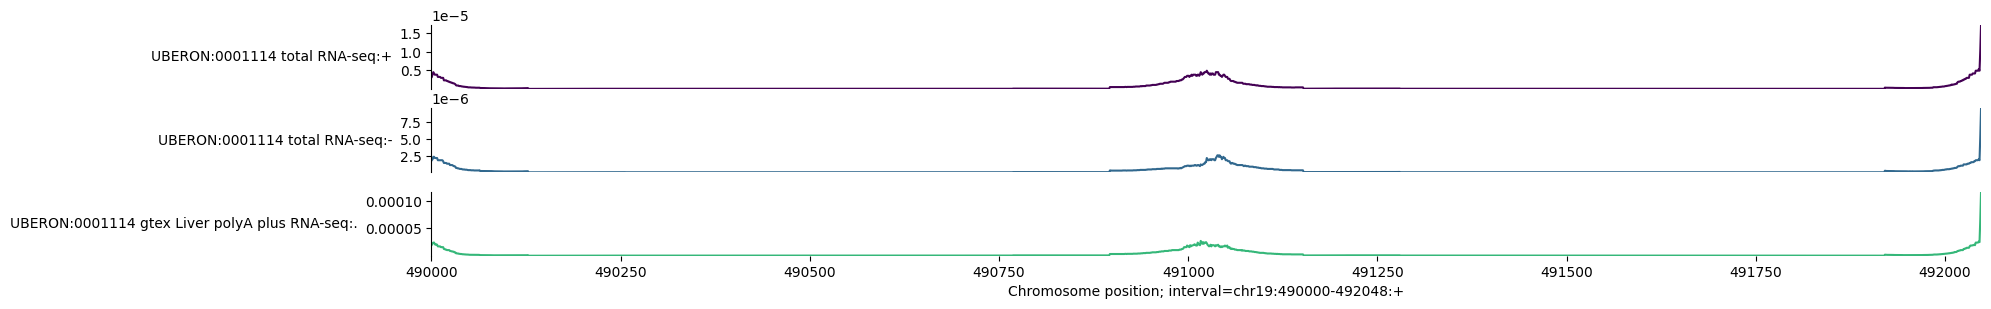

In [ ]:
from pyfaidx import Fasta
import pandas as pd

# Inputs
genome_fasta = "reference_genome.fa"
flank_10kb_bed = "tss_10kb.bed"        # chrom, start, end, gene_id
fimo_matches = "fimo.tsv"              # standard FIMO output
target_gene = "GENE_X"                 # gene of interest
replacement_motif = "ATCGTAGC"         # motif to replace with

# Load genome
genome = Fasta(genome_fasta)

# Load 10kb flanking region
flank_df = pd.read_csv(flank_10kb_bed, sep="\t", names=["chrom", "start", "end", "gene_id"])
gene_region = flank_df[flank_df["gene_id"] == target_gene].iloc[0]

# Load FIMO matches
fimo_df = pd.read_csv(fimo_matches, sep="\t")
fimo_gene = fimo_df[fimo_df["sequence_name"] == f"{gene_region['chrom']}:{gene_region['start']}-{gene_region['end']}"]

# Extract ±500kb region from reference
tss_center = (gene_region["start"] + gene_region["end"]) // 2
big_start = max(0, tss_center - 500_000)
big_end = tss_center + 500_000
big_seq = list(str(genome[gene_region["chrom"]][big_start:big_end]))

# Extract the 10kb region from the big sequence (offset relative to big_start)
flank_start_rel = gene_region["start"] - big_start
flank_end_rel = gene_region["end"] - big_start

# Replace motifs inside the 10kb region
for _, row in fimo_gene.iterrows():
    motif_start_rel = int(row["start"]) - 1 + flank_start_rel  # FIMO is 1-based
    motif_end_rel = motif_start_rel + len(row["matched_sequence"])
    big_seq[motif_start_rel:motif_end_rel] = list(replacement_motif)

# Final sequence as string
final_seq = "".join(big_seq)

# Save result
with open(f"{target_gene}_1Mbp_modified.fa", "w") as f:
    f.write(f">{target_gene}_1Mbp\n")
    for i in range(0, len(final_seq), 60):
        f.write(final_seq[i:i+60] + "\n")


In [ ]:
import pandas as pd
from pyfaidx import Fasta
from Bio.Seq import Seq
from collections import defaultdict

# === Parameters ===
gene_name = "PRRX1"
genome_fasta = "GRCh38.fa"  # Must be indexed with samtools faidx
gtf_file = "genes.gtf"
fimo_file = "fimo.tsv"
replacement_motif = "ATGCGT"  # Replacement motif
output_original = "gene_region_original.fa"
output_replaced = "gene_region_replaced.fa"
region_size = 1_000_000  # 1Mbp

# === Step 1: Get gene coordinates from GTF ===
def get_gene_tss(gtf_file, gene_name):
    gtf = pd.read_csv(gtf_file, sep="\t", comment="#", header=None,
                      names=["chr", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"])
    gene_rows = gtf[(gtf["feature"] == "gene") & (gtf["attribute"].str.contains(f'gene_name "{gene_name}"'))]
    if gene_rows.empty:
        raise ValueError(f"Gene {gene_name} not found in GTF.")
    
    row = gene_rows.iloc[0]
    chrom = row["chr"]
    strand = row["strand"]
    tss = row["start"] if strand == "+" else row["end"]
    return chrom, strand, tss

# === Step 2: Extract 1Mbp region around TSS ===
def get_region(chrom, tss, region_size, fasta):
    half = region_size // 2
    start = max(0, tss - half)
    end = tss + half
    seq = fasta[chrom][start:end].seq
    return start, end, seq

# === Step 3: Replace motifs from FIMO ===
def replace_motifs_in_sequence(seq, chrom, start_offset, fimo_df, replacement, strand="+"):
    matches = fimo_df[fimo_df["sequence_name"] == chrom].copy()
    matches = matches[(matches["start"] >= start_offset + 1) & (matches["stop"] <= start_offset + len(seq))]

    # Convert to relative positions
    matches["rel_start"] = matches["start"] - 1 - start_offset
    matches["rel_stop"] = matches["stop"] - start_offset

    matches = matches.sort_values("rel_start", ascending=False)

    for _, row in matches.iterrows():
        s, e, match_strand = int(row["rel_start"]), int(row["rel_stop"]), row["strand"]
        rep_seq = str(Seq(replacement).reverse_complement()) if match_strand == "-" else replacement
        seq = seq[:s] + rep_seq + seq[e:]
    return seq

# === Run the pipeline ===
# Step 1
chrom, strand, tss = get_gene_tss(gtf_file, gene_name)

# Step 2
fasta = Fasta(genome_fasta)
region_start, region_end, original_seq = get_region(chrom, tss, region_size, fasta)

# Step 3
fimo_df = pd.read_csv(fimo_file, sep="\t")
modified_seq = replace_motifs_in_sequence(original_seq, chrom, region_start, fimo_df, replacement_motif, strand)

# === Output FASTA files ===
with open(output_original, "w") as f:
    f.write(f">{gene_name}_original_{chrom}:{region_start}-{region_end}\n{original_seq}\n")

with open(output_replaced, "w") as f:
    f.write(f">{gene_name}_replaced_{chrom}:{region_start}-{region_end}\n{modified_seq}\n")

print("✅ Done! Original and replaced sequences saved.")


In [7]:
GENCODE_ANNOTATION_PATH

'/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/gencode.v43.annotation.gtf.gz'

In [54]:


TFS = ['FLI1','TAL1']


for tf in TFS:
    tfid = gene_name_id_map.get(tf)
    print(tfid in activatorlist)
    print(tfid in repressorlist)
    print(tfid in conflictedlist)
    

False
False
True
False
False
True
